# Statistics Without Borders - Covid 19 Twitter Analysis

Author: Heli Vora
Date: 5/23/2020

# Part 2

Using supervised learning to classify already annonated tweets:

### 1. Data Loading and Collection

In [2]:
import pandas as pd
import numpy as np
import pickle
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# For reproducibility
np.random.seed(1237)
import warnings; warnings.simplefilter('ignore')


In [3]:
#Loading client labelled data
df_test = pd.read_csv("client_labels_test.csv")
df_test.head(5)



,X1,id,FINAL_LABEL,text
0,0,1.251010e+18,IRRELEVANT,If ya chick ain't answering face time n she no...
1,12,1.248690e+18,IRRELEVANT,🙌🏾🙌🏾🙌🏾 Black organizers and youth are on the f...
2,15,1.249760e+18,IRRELEVANT,😩🗣If I see dis shit 1 more Time Wtf is 13/04/2...
3,19,1.249340e+18,IRRELEVANT,😂😂😂😂😭....man i know some body that does this i...
4,22,1.250110e+18,IRRELEVANT,😂😂😂 It’s Giving Call of Duty Sis 😂 Let Me Get ...


In [4]:
df_train = pd.read_csv("client_labels_train.csv")
df_train.head(5)


,X1,id,FINAL_LABEL,text
0,1,1.251010e+18,IRRELEVANT,i saw someone under that tweet say “nO tAxeS n...
1,2,1.250140e+18,RELEVANT,🧟‍♂️ \nScientists Confirm First Case of COVID-...
2,3,1.250960e+18,IRRELEVANT,“The new requirements are bound to make face c...
3,4,1.250830e+18,IRRELEVANT,NaN
4,5,1.248700e+18,IRRELEVANT,🚨ATTENTION #SmallBizDC Community🚨\nJoin DSLBD ...


I am combining the test and the train set so we could later use cross validation to split data

In [5]:
df_all = df_train.append(df_test)
df_all.shape


(511, 4)

In [6]:
df_all.drop(['X1','id'], axis = 1, inplace = True)

In [7]:
df_all.head(5)


,FINAL_LABEL,text
0,IRRELEVANT,i saw someone under that tweet say “nO tAxeS n...
1,RELEVANT,🧟‍♂️ \nScientists Confirm First Case of COVID-...
2,IRRELEVANT,“The new requirements are bound to make face c...
3,IRRELEVANT,NaN
4,IRRELEVANT,🚨ATTENTION #SmallBizDC Community🚨\nJoin DSLBD ...


### 2. Data Cleansing

Using our user defined function to clean the tweets, remove emojis, hyperlinks, urls etc, deleting duplicates, removing nones


In [8]:
###Not removing Numbers to capture covid 19, percentage rate etcs


## Removing HTML encoding
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', str(text))
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z0-9]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()


testing = df_all['text']

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [9]:
df_all['clean_text'] = df_all['text'].apply(lambda x : tweet_cleaner(x))    

In [10]:
df_all.drop(['text'], axis = 1, inplace = True)
df_all.head(5)

,FINAL_LABEL,clean_text
0,IRRELEVANT,i saw someone under that tweet say no taxes no...
1,RELEVANT,scientists confirm first case of covid 19 tran...
2,IRRELEVANT,the new requirements are bound to make face co...
3,IRRELEVANT,nan
4,IRRELEVANT,attention smallbizdc community join dslbd and ...


In [11]:
df_all_clean = df_all[df_all.clean_text != 'nan']
df_all_clean.shape

(469, 2)

### 3. Exploratory Data Analysis

Checking for number of tweets in each category

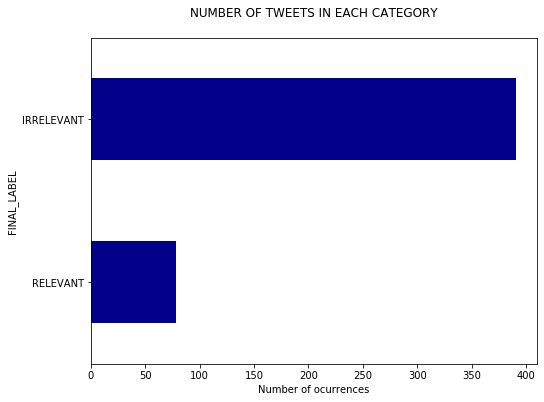

In [12]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue']
df_all_clean.groupby('FINAL_LABEL').clean_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);



In [13]:
df_all_clean.head(5)

,FINAL_LABEL,clean_text
0,IRRELEVANT,i saw someone under that tweet say no taxes no...
1,RELEVANT,scientists confirm first case of covid 19 tran...
2,IRRELEVANT,the new requirements are bound to make face co...
4,IRRELEVANT,attention smallbizdc community join dslbd and ...
5,IRRELEVANT,and i want my face in some pussy


Splitting into test and train sets

In [14]:
#Now lets split the data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_all_clean, shuffle = True, stratify = df_all_clean.FINAL_LABEL, random_state = 50,test_size=0.22)
train.shape, test.shape

((365, 2), (104, 2))

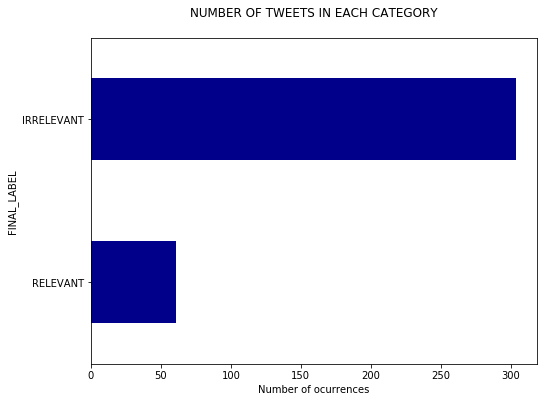

In [15]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue']
train.groupby('FINAL_LABEL').clean_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

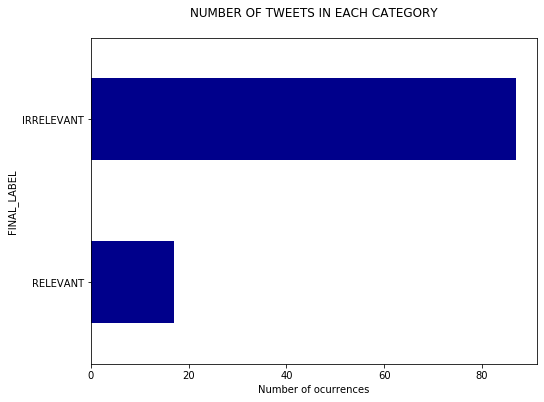

In [16]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue']
test.groupby('FINAL_LABEL').clean_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

We need to ensure that the train and test sets come from the same distribution. We are using adverserial validation to validate this. I am using a simple Bag of WOrds vectorized logistic regression model and then evaluate the AUC

In [17]:
# Adverserial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold


def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(loss = 'log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        # Run RF
        rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Random Forest AUC : {:.3f}'.format(rf_auc.mean())) 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
x_train_a = bow.fit_transform(train.clean_text.values)
x_test_a = bow.transform(test.clean_text.values)
adversarial_validation(x_train_a, x_test_a[:50])

Logisitic Regression AUC : 0.431
Random Forest AUC : 0.442


The low AUC values suggest that the train and test set have similar distribution. We can even confirm below that both training and test sets have same % of positive class


In [19]:
print('Train Positive Class % : {:.1f}'.format((sum(train.FINAL_LABEL == 'RELEVANT')/train.shape[0])*100))
print('Test Positive Class % : {:.1f}'.format((sum(test.FINAL_LABEL == 'RELEVANT')/test.shape[0])*100))
print('Train Size: {}'.format(train.shape[0]))
print('Test Size: {}'.format(test.shape[0]))

Train Positive Class % : 16.7
Test Positive Class % : 16.3
Train Size: 365
Test Size: 104


### 4. Fitting various models


Next, I am going to examin the performance of different models on our dataset. First, I am using a simple logistic model. I am embedding our data using both bag of words method and Tf-idf method to test the performance

#### Model 1. Bag of words/Tf-idf + Logistic Regression (Baseline)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
sns.set_palette("muted")
    

def calc_f1(p_and_r):
    p, r = p_and_r
    return (2*p*r)/(p+r)


# Print the F1, Precision, Recall, ROC-AUC, and Accuracy Metrics 
# Since we are optimizing for F1 score - we will first calculate precision and recall and 
# then find the probability threshold value that gives us the best F1 score

def print_model_metrics(y_test, y_test_prob, confusion = False, verbose = True, return_metrics = False):

    precision, recall, threshold = precision_recall_curve(y_test, y_test_prob, pos_label = 1)
    
    #Find the threshold value that gives the best F1 Score
    best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
    best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]
    
    # Calulcate predictions based on the threshold value
    y_test_pred = np.where(y_test_prob > best_threshold, 1, 0)
    
    # Calculate all metrics
    f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = 'binary')
    roc_auc = roc_auc_score(y_test, y_test_prob)
    acc = accuracy_score(y_test, y_test_pred)
    
    
    if confusion:
        # Calculate and Display the confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)

        plt.title('Confusion Matrix')
        sns.set(font_scale=1.0) #for label size
        sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['No Clickbait', 'Clickbait'], yticklabels = ['No Clickbait', 'Clickbait'], annot_kws={"size": 14}, cmap = 'Blues')# font size

        plt.xlabel('Truth')
        plt.ylabel('Prediction')
        
    if verbose:
        print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
    if return_metrics:
        return np.array([f1, best_precision, best_recall, roc_auc, acc])
    
    

# Run Simple Log Reg Model and Print metrics
from sklearn.linear_model import SGDClassifier

# Run log reg 10 times and average the result to reduce predction variance
def run_log_reg(train_features, test_features, y_train, y_test,  alpha = 1e-4, confusion = False, return_f1 = False, verbose = True):
    metrics = np.zeros(5)
    for _ in range(10):
        log_reg = SGDClassifier(loss = 'log', alpha = alpha, n_jobs = -1, penalty = 'l2')
        log_reg.fit(train_features, y_train)
        y_test_prob = log_reg.predict_proba(test_features)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, confusion = confusion, verbose = False, return_metrics = True)
    metrics /=10
    if verbose:
        print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    if return_f1:
        return f1
    return log_reg

In [21]:
y_train = np.where(train.FINAL_LABEL.values == 'RELEVANT', 1, 0)
y_test = np.where(test.FINAL_LABEL.values == 'RELEVANT', 1, 0)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##########LR+Bag of Words
bow = CountVectorizer()
x_train = bow.fit_transform(train.clean_text.values)
x_test = bow.transform(test.clean_text.values)
run_log_reg(x_train, x_test, y_train, y_test)

############## Logistic Regression + Tfidf 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train.clean_text.values)
x_test = tfidf.transform(test.clean_text.values)
run_log_reg(x_train, x_test, y_train, y_test)


F1: 0.153 | Pr: 0.156 | Re: 0.194 | AUC: 0.584 | Accuracy: 0.808 

F1: 0.000 | Pr: 0.000 | Re: 0.000 | AUC: 0.610 | Accuracy: 0.835 



SGDClassifier(loss='log', n_jobs=-1)

The baseline models aren't doing that great, even though the accuracy is high, it due to the low number of records and imbalanced nature of the dataset. From now on, I will focus on increasing the recall metric i.e. to capture relevant tweets more correctly

#### 2. Using Glove Twitter Embeddings to embed the dataset

I am going to use GLOVE's twitter embedding to vectorize the tweets. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Glove is trained on a huge number of tweets already and can help us capture the underlying context in the tweets

In [22]:
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

In [23]:
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [24]:
from tqdm import tqdm_notebook
from nltk import word_tokenize
from sklearn.preprocessing import scale
from pymagnitude import *
#glove = Magnitude("./vectors/glove.6B.50d.magnitude")
#
x_train_g = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in train.clean_text.values])
               )
x_test_g =scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in test.clean_text.values])
               )
run_log_reg(x_train_g, x_test_g, y_train, y_test)

F1: 0.384 | Pr: 0.283 | Re: 0.788 | AUC: 0.696 | Accuracy: 0.618 



SGDClassifier(loss='log', n_jobs=-1)

Here we can see some improvements from the baseline in terms of precision and recall. However, it could still be improved. Once of the major problem we are facing is that the dataset is imbalanced, only 17% of the data is relevant. Next, I am going to use SMOTE to upsample the minority class to make the data somewhat evenly distributed.

In [25]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 0) 
X_train_res, y_train_res = sm.fit_sample(x_train_g, y_train)

In [26]:
X_train_res.shape

(608, 200)

In [27]:
y_train_res.shape

(608,)

In [28]:
unique, counts = np.unique(y_train_res, return_counts=True)
dict(zip(unique, counts))

{0: 304, 1: 304}

We can see that smote has synthetically created records to make the classes balanced

Now that we have applied GLOVE embeddings and SMOTE, I am going to train three different models that are tuned using Grid Search Cross Validation. My goal is not just to improve accuracy but to capture as many relevant tweets correctly as we can

#### Model 4 : SMOTE + Tuned Logistics Regression using Grid Search 

In [29]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


# Create a new skelarn 'scorer' that uses our print_model_metrics function
def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1
    
score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)



# Since we want to use a predefined Test/Val set, we'll use PredefinedSplit and pass it as the CV parameter
# We need to merge both the datasets and label 0 for test and -1 for the train set

X = sparse.vstack((X_train_res, x_test_g))
test_fold = [-1 for _ in range(X_train_res.shape[0])] + [0 for _ in range(x_test.shape[0])]
y = np.concatenate([y_train_res, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)

##### 1. SMOTE + Tuned Logistic Regression

In [30]:
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss = 'log')
lr_params = {'alpha' : [10**(-x) for x in range(7)],
             'penalty' : ['l1', 'l2', 'elasticnet'],
             'l1_ratio' : [0.15, 0.25, 0.5, 0.75]}
best_params, best_f1 = run_grid_search(lr, lr_params, X, y)
print('Best Parameters : {}'.format(best_params))
lr = SGDClassifier(loss = 'log', 
                   alpha = best_params['alpha'], 
                   penalty = best_params['penalty'], 
                   l1_ratio = best_params['l1_ratio'])
lr.fit(X_train_res, y_train_res)
lr_test_prob = lr.predict_proba(x_test_g)[:,1]
print_model_metrics(y_test, lr_test_prob)

Best Parameters : {'alpha': 0.01, 'l1_ratio': 0.25, 'penalty': 'l1'}
F1: 0.000 | Pr: 0.000 | Re: 0.000 | AUC: 0.699 | Accuracy: 0.837 



In [31]:
y_pred_lr = np.where(lr_test_prob>0.5,1,0)

Text(0.5, 1, 'CONFUSION MATRIX - LinearSVC\n')

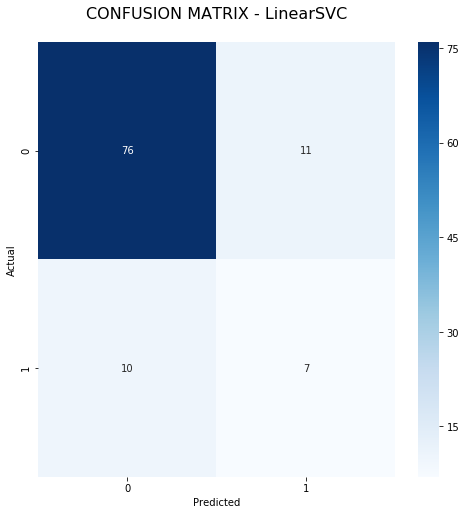

In [32]:
conf_mat = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)



##### Model 2 :  SMOTE  + Support Vector

In [33]:
def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))

In [34]:
from sklearn.svm import SVC

svm = SVC(probability = True)
svm_params = {'C' : [10**(x) for x in range(-1,4)],
             'kernel' : ['poly', 'rbf', 'linear'],
             'degree' : [2, 3]}

best_params, best_f1 = run_grid_search(svm, svm_params, X, y)

print('Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

svm = SVC(C = best_params['C'], kernel = best_params['kernel'], degree = best_params['degree'], probability = True)
fit_n_times(svm, X_train_res, y_train_res, x_test_g, y_test)

Best Parameters : {'C': 100, 'degree': 3, 'kernel': 'poly'}
Best F1 : 0.39344262295081966
F1: 0.394 | Pr: 0.289 | Re: 0.771 | AUC: 0.695 | Accuracy: 0.642 



In [35]:
svc_test_prob = svm.predict_proba(x_test_g)[:,1]
y_pred_sv = np.where(svc_test_prob>0.5,1,0)

Text(0.5, 1, 'CONFUSION MATRIX - LinearSVC\n')

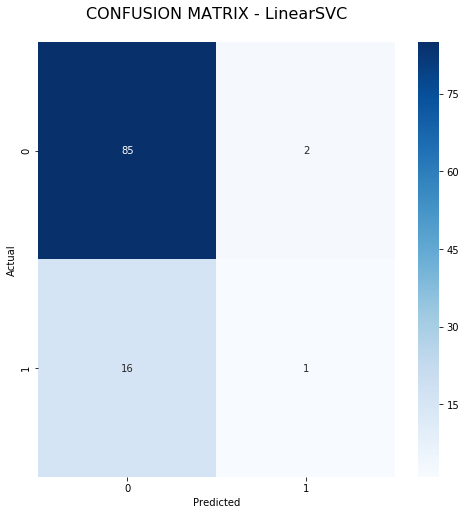

In [36]:
conf_mat = confusion_matrix(y_test, y_pred_sv)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)


##### Model 3. SMOTE + Tuned XGBoost

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs = -1)

xgb_params = { 'n_estimators' : [10, 100, 200, 500], 
               'max_depth' : [1, 2, 3, 7],
               'learning_rate' : [0.1, 0.2, 0.01, 0.3],
               'reg_alpha' : [0, 0.1, 0.2]
}

best_params, best_f1 = run_grid_search(xgb, xgb_params, X, y)

print('Best Parameters : {}'.format(best_params))
xgb = XGBClassifier(n_estimators = best_params['n_estimators'],
                            learning_rate = best_params['learning_rate'],
                            max_depth = best_params['max_depth'], 
                            reg_alpha = best_params['reg_alpha'], 
                            n_jobs = -1)
fit_n_times(xgb, X_train_res, y_train_res, x_test_g, y_test)

Best Parameters : {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 10, 'reg_alpha': 0}
F1: 0.429 | Pr: 0.370 | Re: 0.588 | AUC: 0.695 | Accuracy: 0.769 



In [38]:
xgb_test_prob = xgb.predict_proba(x_test_g)[:,1]
y_pred_xgb = np.where(xgb_test_prob>0.5,1,0)

Text(0.5, 1, 'CONFUSION MATRIX - LinearSVC\n')

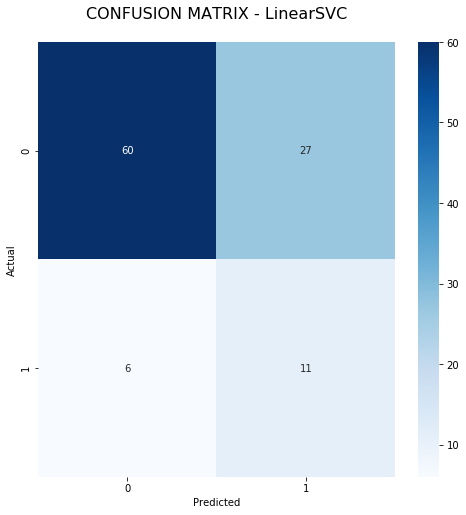

In [39]:
conf_mat = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)

Overall, the Tuned XGBoost Model (Glove + SMOTE) does a really good job at predicting the relevant classes correctly

In [44]:
masterdata = pd.read_csv("MasterFile.csv",encoding = 'utf-8')

In [45]:
masterdata.head(5)

,Unnamed: 0,Device,Ext URL,FullText,HashTags,Location,Retweet,TimeStamp,TweetID,isQuote
0,0,"<a href=""http://twitter.com/download/android"" ...",[],@VPrasadMDMPH The twitter account associated w...,[],"Palo Alto, CA",False,Tue Apr 21 01:41:05 +0000 2020,1.252412e+18,False
1,1,"<a href=""http://twitter.com/download/iphone"" r...","[{'url': 'https://t.co/r8Dok3PtnW', 'expanded_...",Cytokine release syndrome in severe COVID-19 |...,[],"Palo Alto, CA",False,Mon Apr 20 18:37:38 +0000 2020,1.252305e+18,False
2,2,"<a href=""http://twitter.com/download/android"" ...","[{'url': 'https://t.co/tlxzOinpub', 'expanded_...","#RonDeSantis hides ""crucial information"" about...",['RonDeSantis'],"Palo Alto, CA",False,Mon Apr 20 17:37:49 +0000 2020,1.252290e+18,False
3,3,"<a href=""http://twitter.com/download/iphone"" r...",[],@CAG_ID_Doc Great discussion about ARDS phenot...,[],"Palo Alto, CA",False,Mon Apr 20 17:17:12 +0000 2020,1.252285e+18,False
4,4,"<a href=""https://tapbots.com/software/tweetbot...","[{'url': 'https://t.co/B1eb13muVO', 'expanded_...",Super interesting ‘change in mobility’ dashboa...,[],"Palo Alto, CA",False,Mon Apr 20 15:22:58 +0000 2020,1.252256e+18,False


In [46]:
masterdata['clean_text'] = masterdata['FullText'].apply(lambda x : tweet_cleaner(x))    

In [48]:
newdata = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in masterdata.clean_text.values]))

In [49]:
newdata.shape

(168626, 200)

In [53]:
predictions = pd.DataFrame(xgb.predict(newdata))

In [54]:
predictions.shape

(168626, 1)

In [92]:
final_pred = pd.merge(masterdata['FullText'],predictions, left_index = True, right_index = True)

In [93]:
final_pred.head(15)

,FullText,0
0,@VPrasadMDMPH The twitter account associated w...,0
1,Cytokine release syndrome in severe COVID-19 |...,1
2,"#RonDeSantis hides ""crucial information"" about...",1
3,@CAG_ID_Doc Great discussion about ARDS phenot...,0
4,Super interesting ‘change in mobility’ dashboa...,0
5,#Trump and the #gop are actually denying neede...,1
6,Far more COVID-19 cases in Silicon Valley than...,1
7,"We need tech more than ever, but that doesn't ...",1
8,https://t.co/e9aut17jma @OxfordJournals @IDSAI...,1
9,@stlouisfed @CouncilEconEd Sorry but his answe...,0


In [94]:
final_pred.shape

(168626, 2)

In [95]:
final_pred.columns = ['Tweet','Prediction']

In [96]:
def annotate_label(x):
    pred = ''
    if x == 1:
        pred = "Relevant"
    else:
        pred = "Irrelevant"
    return(pred)

In [103]:
final_pred['PredictedLabels'] = final_pred['Prediction'].apply(lambda x : annotate_label(x))

In [104]:
final_pred.head(3)

,Tweet,Prediction,PredictedLabels
0,@VPrasadMDMPH The twitter account associated w...,0,Irrelevant
1,Cytokine release syndrome in severe COVID-19 |...,1,Relevant
2,"#RonDeSantis hides ""crucial information"" about...",1,Relevant


In [105]:
final_pred.drop(['Prediction'], axis = 1, inplace = True)

In [106]:
final_pred.to_csv('Predicted_Master.csv',encoding = 'utf-8',index = False)